<a id='top'></a>

# CSCI3022 F21
# Homework 8: Confidence, Testing, Small Samples
***

**Name**: Olivia Golden

***

This assignment is due on Canvas (as .ipynb) and Gradescope (as a .pdf) by **MIDNIGHT on Wed 17 Nov**. Your solutions to theoretical questions should be done in Markdown directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) |
---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as stats
import itertools
%matplotlib inline

<br>

---
<a/ id='p1'></a>
[Back to top](#top)
## Problem 1 (Small Samples; 20 points)

Consider the `hubble.csv` data set we used in nb15. In that example, we used the large-sample normal approximation and used it to calculate a confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs (column `x` of the data).

Unfortunately, the data was only 24 observations!  What could we have done instead?


In [4]:
# Path to the data - select the path that works for you 
file_path = 'hubble.csv'

# Load the data into a DataFrame 
df = pd.read_csv(file_path)
df.head(5)

24



**Part A**:

Make a histogram of the data and overlay the theoretical density of the normal with mean $\bar{X}$ and variance $s^2$.  How closely do the data follow the histogram?


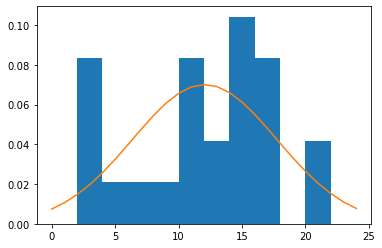

In [3]:
plt.hist(df['x'], density=True)
mean=np.mean(df['x'])
std=np.std(df['x'])
x = np.arange(0,25)
plt.plot(stats.norm.pdf(x, loc = mean, scale =std))

It doesn't follow the normal curve very closely.  

**Part B**:

Things may not look perfectly normal in part A... but let's perform the tests that require normality anyways:

For Part B only, assume each observation is independent and identically distributed as a normal random variable.

- Create a 95% confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the standard deviation of a galaxy's distance from Earth in Mega parsecs.

In [4]:
print("95% confidence for the mean")
print(stats.norm.interval(alpha=0.95, loc=np.mean(df['x']), scale=stats.sem(df['x'])))
print("95% confidence for the std")

alpha = 0.05
nx=25
sx=np.std(df['x'])
c2, c1 = stats.chi2.ppf(alpha/2, nx-1), stats.chi2.ppf(1-alpha/2, nx-1)
print((np.sqrt((nx-1)*sx*sx/c1), np.sqrt((nx-1)*sx*sx/c2)))


95% confidence for the mean
(9.728282115953512, 14.380884550713152)
95% confidence for the std
(4.444647869059267, 7.918745978839454)


**Part C**:

For part C only, assume each observation is independent and identically distributed but is **not** normally distributed.  Instead, use bootstrapping to:

- Create a 95% confidence interval for the mean of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the standard deviation of a galaxy's distance from Earth in Mega parsecs.
- Create a 95% confidence interval for the interquartile range (both lower and upper quartiles) of a galaxy's distance from Earth in Mega parsecs.

Use 10,000 bootstrapped samples to make the statistics above.

In [5]:
means=[]
std=[]
upper=[]
lower=[]
nsamp=10000
X=df['x']
for i in range(nsamp):
    newX=np.random.choice(X, size=len(X), replace=True)
    means.append(np.mean(newX))
    std.append(np.std(newX))
    upper.append(np.quantile(newX, .75))
    lower.append(np.quantile(newX, .25))
    
CI_mean=np.percentile(means, [5,95])
CI_std=np.percentile(std, [5,95])
CI_upper=np.percentile(upper, [5,95])
CI_lower=np.percentile(lower, [5,95])
print('95% CI for mean')
print(CI_mean)
print('95% CI for STD')
print(CI_std)
print('95% CI for Upper Quartile')
print(CI_upper)
print('95% CI for Lower Quartile')
print(CI_lower)

95% CI for mean
[10.13391667 13.9909375 ]
95% CI for STD
[4.44662861 6.54172521]
95% CI for Upper Quartile
[14.755  17.7625]
95% CI for Lower Quartile
[ 3.5275 11.6175]


<br>

---
<a/ id='p2'></a>
[Back to top](#top)

## Problem 2 (Hypotheses and Simulation; 25 points)
***

In hypothesis testing, we typically ask "what is the probability of observing *this* test statistic if everything is fair/random."  Often, we reach this probability via test statistics on known distributions (`Z`, `T`, proportions, sample variances, etc.).  We then draw conclusions like "that doesn't look random!  It's extremely unlikely to happen under the **null hypothesis**, so we reject that hypothesis."

However, if we can **simulate**, we can leverage our (arbitrarily) large sample size to generate the same probabilities used for hypothesis tests *without* converting into an intermediate distribution.  In other words, you should make **no distributional assumptions** in this problem.

Suppose we're about to play a newly invented "game" of chance.

In this game, you:

    1) Roll a single (fair) 6-sided die.  The value of the upward face of the die is your score.
    
    2) Roll a number of 6-sided dice equal to your score in 1).  Add the value of the upward faces of the die to your score.
    
    3) Continue to roll a number additional dice equal to exactly what was face-up on your previous roll, adding the result to your score.
    
    4) If at any time, you've rolled 20 or more dice with the *same* value showing, do not roll again.  Simply add the current result to your score and stop.

Not being in the mood to solve an incredibly tedious discrete probability problem, you decide to *simulate* the game to get a feeling for what a reasonable score is.

One simulation might be:

    1) Zach rolls a '5'.  Score is 5.
    2) Zach rolls '1, 2, 2, 5, 6'.  Add 16, so score is now 21.
    3) Zach rolls 16 dice.  He adds the resulting faces (in this case, 51) to his score, which is now 72.
    4) Zach rolls 51 dice and adds the resulting 163 to his score, making a score of 235.
    5) He rolls once more - 163 dice - adding 500 for a score of 735.  This is his final score, as this last roll included 35 "4's" as the most common die face (and 35 is 20 or more).

**Part A**: Simulate 10,000 "plays" of this game, saving all of the final scores as well as the first roll of each.  Report the average final score.

NB: `np.unique` can be a good way to check if you have 20 or more of one face.

In [6]:
import random

def game():
    first_roll=[] #initialize arrays
    final_score=[]
    for _ in range(10000): #repeat 1000 times
        roll=random.randint(1,6) #fair die
        first_roll.append(roll) 
        score=roll
        sum_prev=roll 
        a=0 #break out of loop 
        while (a==0):
            sum1=0 #set iteration sum to 0
            rolls=[]
            for i in range(sum_prev): #for the previous roll sum
                roll=random.randint(1,6)
                sum1+=roll
                rolls.append(roll)
            score+=sum1 #add to total score
            sum_prev=sum1 #save to use for next roll 
            counts=np.unique(rolls, return_counts=True)[1] #counts of how many times a number appears
            for i in range(len(counts)): 
                if (counts[i]>=20): #if larger than 19
                    final_score.append(score) #add final sscore
                    a=1
                    break #break
    return [first_roll, final_score]


print("Average Final Score")
scores=game()[1]
average=np.mean(scores)
print(average)

Average Final Score
890.8853


**Part B**: Create a density histogram of the final scores.  Label axes, and include a title.  Does this appear to be normally distributed? Why would we care?
    

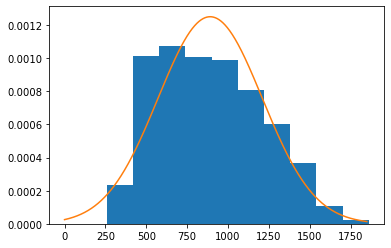

In [7]:
plt.hist(scores, density=True)
mean=np.mean(scores)
std=np.std(scores)
x = np.arange(0,1850)
plt.plot(stats.norm.pdf(x, loc = mean, scale =std))

It is not normally distributed, so we cannot use CLT.

**Part C**: Your friend (who really hates losing) approaches you and says "I'm pretty sure this game is unfair and your dice are loaded.  I played 10 times and my average score was a 500!  There's no way that should happen on fair dice."

**C1**: What is your estimated probability that a single game scores 500 or less?
    
**C2**: What would you estimate the probability to be that an average score of 10 games is 500 or less?
     
**C3**: Suppose we were to create a 1-tailed hypothesis test of the form "I reject the null hypothesis that fair dice were used if a set of 10 games has an average score less than or equal to $c$."  What would you choose for $c$ if you wanted a probability of Type I error of .01 or less?

**C4**: What do you tell your friend?

In [8]:
scores_500=0
for i in range(len(scores)):
    if (scores[i]<=500):
        scores_500+=1
print('Probability of a score of 500 or less')
scores_500=scores_500/10000
print(scores_500)

def test(s):
    count=0
    count1=0
    for i in range(0,len(scores),10):
        newX=scores[i:i+9]
        if (np.mean(newX)<=s): #if mean is less than or equal to input, increment counter
            count+=1
        count1+=1
    return (count/count1)  

print('Probability that an average score of 10 games is 500 or less')
print(test(500))

alpha=1
c=round(average)
while(alpha>.01):
    alpha=test(c)
    if (alpha<=.01):
        print('Value of C')
        print(c)
        break
    else:
        c-=1        

Probability of a score of 500 or less
0.1134
Probability that an average score of 10 games is 500 or less
0.0
Value of C
651


Since the average of their 10 games was 500 which is below c, we would reject the null hypothesis that fair dice were used.

**Part D**: You decide that if you wanted to cheat your friend, it would make way more sense to weight the *first* die roll than try to find tens or hundreds of weighted dice.  Carefully justifying your answer with both numerical and visual results, how would you weight the die on the *first* roll to **minimize** your friends score?

I would weigh the first roll so that the lower numbers were more likely to get chosen.  1,2,3 would have a $\frac{10}{33}$ probabiltiy of getting chosen while 4,5,6 would have a $\frac{1}{33}$ probability of getting chosen.

In [9]:
def game_weighted():
    first_roll=[]
    final_score=[]
    for _ in range(10000):
        if(random.random()<=10/11): #higher chance of getting a lower intial roll
            roll=random.randint(1,3)
        else:
            roll=random.randint(4,6)
        first_roll.append(roll)
        score=roll
        sum_prev=roll
        a=0
        while (a==0):
            sum1=0
            rolls=[]
            for i in range(sum_prev):
                roll=random.randint(1,6)
                sum1+=roll
                rolls.append(roll)
            score+=sum1
            sum_prev=sum1
            counts=np.unique(rolls, return_counts=True)[1]
            for i in range(len(counts)):
                if (counts[i]>=20):
                    final_score.append(score)
                    a=1
                    break
    return [first_roll, final_score]

print("Average Final Score")
scores=game_weighted()[1]
average=np.mean(scores)
print(average)

Average Final Score
848.0837


(array([1.11111111e-04, 1.20350242e-03, 1.33876812e-03, 1.04891304e-03,
        7.92874396e-04, 6.15338164e-04, 4.87922705e-04, 3.02536232e-04,
        1.15338164e-04, 2.23429952e-05]),
 array([ 232. ,  397.6,  563.2,  728.8,  894.4, 1060. , 1225.6, 1391.2,
        1556.8, 1722.4, 1888. ]),
 <BarContainer object of 10 artists>)

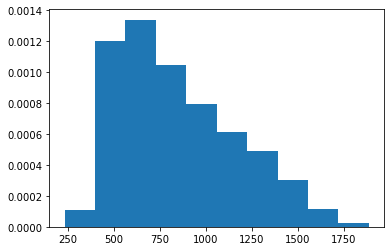

In [10]:
plt.hist(scores, density=True)

The new average final score is less than the original by around 40 points.  In addition, the histogram seems to be right skewed, suggesting more, lower scores.